# Assignment: Call center data modeling

### CS146
### by Milana Stetsenko
### January 28, 2021

# Part 1: 98% Confidence Interval for 24 hours

(The code for the 98% confidence interval for one hour is taken from the in-class activity)

In [1]:
#loading the library

import numpy as np
import scipy as sp
import scipy.stats as sts
import matplotlib.pyplot as plt
from scipy.stats import gamma
import random
%matplotlib inline

In [2]:
# Load the data set containing durations between calls arriving at the call
# center during 1 day. All values are in minutes.
waiting_times_day = np.loadtxt('https://course-resources.minerva.kgi.edu/uploaded_files/mke/00124343-8397/call-center.csv')

# Display some basic information about the data set.
print('Size of data set:', len(waiting_times_day))
print('First 3 values in data set:', waiting_times_day[:4])
print('Sum of data set:', sum(waiting_times_day))

Size of data set: 5856
First 3 values in data set: [30.   3.4  3.2  2.3]
Sum of data set: 1441.6838153800093


## Data Pre-Processing

In [3]:
# Make 24 empty lists, one per hour.
waiting_times_per_hour = [[] for _ in range(24)]

# Split the data into 24 separate series, one for each hour of the day.
current_time = 0
for t in waiting_times_day:
    current_hour = int(current_time // 60)
    current_time += t
    waiting_times_per_hour[current_hour].append(t)

for hour, calls_in_hour in enumerate(waiting_times_per_hour):
    print(f'{hour:02}:00-{hour + 1:02}:00 - {len(calls_in_hour)} calls')

00:00-01:00 - 5 calls
01:00-02:00 - 4 calls
02:00-03:00 - 6 calls
03:00-04:00 - 8 calls
04:00-05:00 - 26 calls
05:00-06:00 - 53 calls
06:00-07:00 - 93 calls
07:00-08:00 - 173 calls
08:00-09:00 - 254 calls
09:00-10:00 - 345 calls
10:00-11:00 - 496 calls
11:00-12:00 - 924 calls
12:00-13:00 - 858 calls
13:00-14:00 - 382 calls
14:00-15:00 - 185 calls
15:00-16:00 - 207 calls
16:00-17:00 - 263 calls
17:00-18:00 - 419 calls
18:00-19:00 - 531 calls
19:00-20:00 - 400 calls
20:00-21:00 - 137 calls
21:00-22:00 - 51 calls
22:00-23:00 - 20 calls
23:00-24:00 - 16 calls


## Plot the number of calls per hour


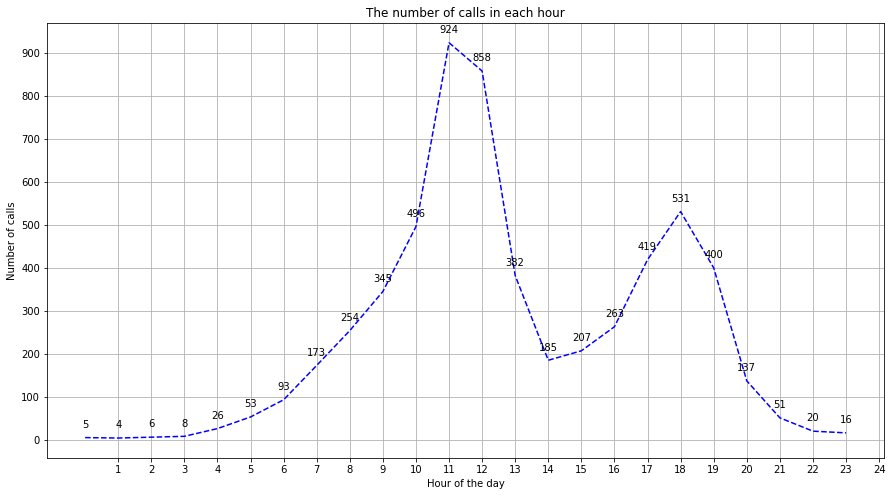

In [4]:
n_calls = [None for i in range (24)]
hour = [i for i in range(0,24)]


plt.figure(figsize=(15, 8))

for i, calls_in_hour in enumerate(waiting_times_per_hour):
    n_calls[i] = len(calls_in_hour)
plt.plot(n_calls,  'b--')
plt.title("The number of calls in each hour")
plt.xticks([i for i in range(1,25, 1)])
plt.yticks ([j for j in range (0,1000, 100)])
plt.ylabel("Number of calls")
plt.xlabel("Hour of the day")
plt.grid(True)


for x,y in zip(hour,n_calls):

    label = "{:}".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # this is the point to label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center') # horizontal alignment can be left, right or center

## Task 2: Plot a histogram of the durations for one hour
Take the data for the 9th hour (so between 9am and 10am) and plot a histogram showing the distribution over waiting times between calls during that hour.

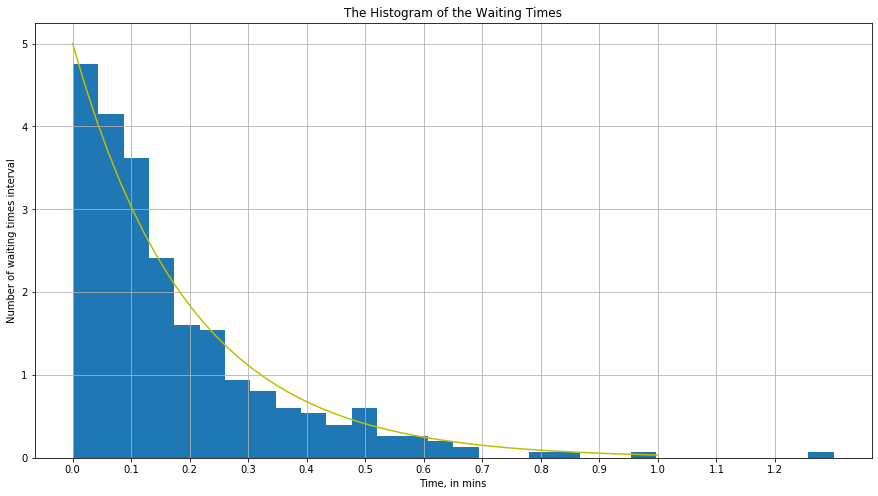

In [5]:
#selecting the 9th hour
hour_index = 9
waiting_times_hour = waiting_times_per_hour[hour_index]

#increasing the size of the figure
plt.figure(figsize=(15, 8))
x = np.linspace (0, 1) 


#plotting the line of best fit - pdf; and the histogram as a density (normalization)
y1 = sts.gamma.pdf(x, a = 1, scale =1/5)
plt.plot(x, y1, "y-", label=(r'$\alpha=29, \beta=3$')) 


plt.hist(waiting_times_hour, bins = 30, density = True)



#customizing and formating the histogram
plt.xticks([i/10.0 for i in range(0,13, 1)])
plt.ylabel('Number of waiting times interval')
plt.xlabel('Time, in mins')
plt.title("The Histogram of the Waiting Times")
plt.grid(True)



plt.show()


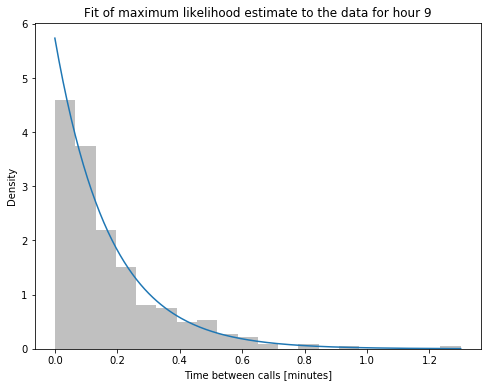

In [6]:
# Exponential distribution with maximum likelihood fit to the data
lambda_ = 1 / np.mean(waiting_times_hour)
distribution = sts.expon(scale=1/lambda_)

plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20, density=True, color='#c0c0c0')
x = np.linspace(0, max(waiting_times_hour), 200)
y = distribution.pdf(x)
plt.plot(x, y)
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Density')
plt.title(f'Fit of maximum likelihood estimate to the data for hour {hour_index}')
plt.show()

## Bayesian Inference for the 9th hour

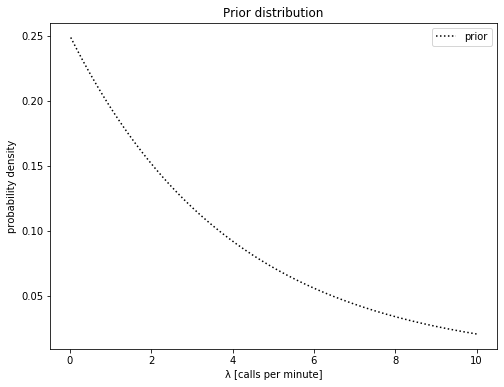

In [7]:
# DEFINE THE PRIOR DISTRIBUTION


def prior(lambda_):
    
    """
    This function takes 1 input, namely the parameter value (λ) at which to
    compute the prior probability density. 

    """
    return sts.gamma(1, scale=1/0.25).pdf(lambda_)

# PLOT THE PRIOR
lambdas = np.linspace(0, 10, 501)[1:]
plt.figure(figsize=(8, 6))
plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Prior distribution')
plt.legend()
plt.show()

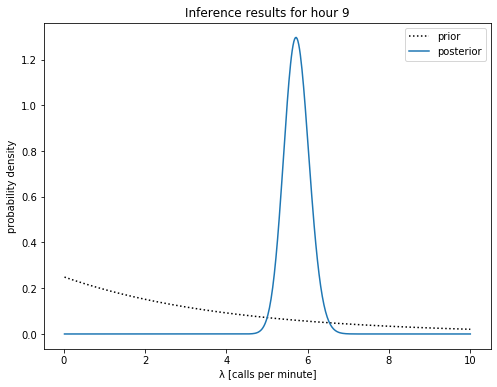

In [8]:
# DEFINE THE LIKELIHOOD FUNCTION
#


def likelihood(lambda_, datum):
    """
    # This function takes 2 inputs, namely the parameter (λ) value at which to
# compute the likelihood and a value from the data set. You need to evaluate
# the exponential distribution of the datum given the parameter value."""
    return sts.expon(scale=1/lambda_).pdf(datum)

# THE POSTERIOR DISTRIBUTION
#
# The function below is provided to help make computing the posterior easier. It
# follows the same pattern as in the previous class, where we multiple the prior
# and the likelihood evaluated at various values of the parameter (λ).
#
# You will see the function uses the logarithms of various distributions. This
# is for numerical reasons. When you multiply lots of likelihood values, the
# result can become very large or very small, causing numerical overflow or
# underflow in Python. Taking logarithms avoids this problem.

def compute_posterior(parameter_values, prior, likelihood, data):
    log_prior = np.log(prior(parameter_values))
    log_likelihood = np.array([
        np.sum(np.log(likelihood(param, data)))
        for param in parameter_values])
    unnormalized_log_posterior = log_prior + log_likelihood
    unnormalized_log_posterior -= max(unnormalized_log_posterior)
    unnormalized_posterior = np.exp(unnormalized_log_posterior)
    area = sp.integrate.trapz(unnormalized_posterior, parameter_values)
    posterior = unnormalized_posterior / area
    return posterior

posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_hour)

# YOU NEED TO PLOT THE PRIOR AND POSTERIOR ON THE SAME AXES.
plt.figure(figsize=(8, 6))
plt.plot(lambdas, prior(lambdas), color='black', linestyle=':', label='prior')
plt.plot(lambdas, posterior, label='posterior')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Inference results for hour {hour_index}')
plt.legend()
plt.show()

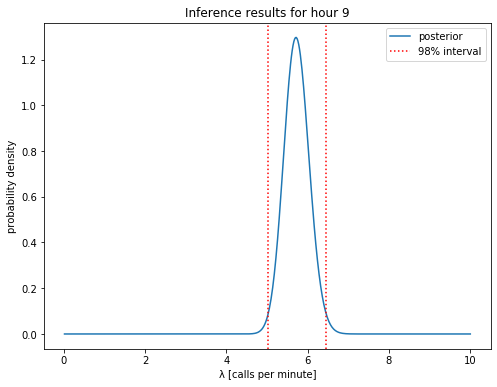

Posterior 98% interval: [5.0200000000000005, 6.46] calls per minute


In [9]:
def compute_percentile(parameter_values, distribution_values, percentile):
    '''
    Compute the parameter value at a particular percentile of the given
    probability distribution values. This function uses the cumulative trapezoid
    integrator in SciPy.

    Inputs:

        parameter_values (array of float) This is the list of parameter values
          at which the probability distribution has been evaluated.

        distribution_values (array of float) This is the list of values of the
          probability density function evaluated at the parameter values above.

        percentile (float) This is the value between 0 and 1 of the percentile
          to compute.

    Returns: (float) The parameter value at the given percentile.
    '''
    cumulative_distribution = sp.integrate.cumtrapz(
        distribution_values, parameter_values)
    percentile_index = np.searchsorted(cumulative_distribution, percentile)
    return lambdas[percentile_index]

percentiles = [compute_percentile(lambdas, posterior, p) for p in [0.01, 0.99]]
plt.figure(figsize=(8, 6))
plt.plot(lambdas, posterior, label='posterior')
plt.axvline(percentiles[0], color='red', linestyle=':', label='98% interval')
plt.axvline(percentiles[1], color='red', linestyle=':')
plt.xlabel('λ [calls per minute]')
plt.ylabel('probability density')
plt.title(f'Inference results for hour {hour_index}')
plt.legend()
plt.show()

print('Posterior 98% interval:', percentiles, 'calls per minute')

Expected value: λ = 5.728695915357027 calls per minute


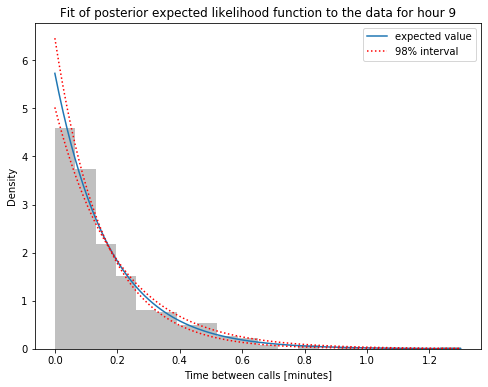

In [10]:
# Get the posterior expected value of λ
lambda_ = sp.integrate.trapz(posterior * lambdas, lambdas)
print('Expected value: λ =', lambda_, 'calls per minute')

# Plot the likelihood function for the expected λ on top of the data histogram
plt.figure(figsize=(8, 6))
plt.hist(waiting_times_hour, bins=20, density=True, color='#c0c0c0')
x = np.linspace(0, max(waiting_times_hour), 200)
plt.plot(x, sts.expon.pdf(x, scale=1/lambda_), label='expected value')
plt.plot(x, sts.expon.pdf(x, scale=1/percentiles[0]), color='red', linestyle=':', label='98% interval')
plt.plot(x, sts.expon.pdf(x, scale=1/percentiles[1]), color='red', linestyle=':')
plt.xlabel('Time between calls [minutes]')
plt.ylabel('Density')
plt.title(f'Fit of posterior expected likelihood function to the data for hour {hour_index}')
plt.legend()
plt.show()

## Extension to 24 hours

In class, we completed the Bayesian data modeling problem for 1 hour of the day. In this assignment, you need to do the same analysis for all 24 hours of the day.
1. Compute a 98% posterior confidence interval over the number of calls per minute (the call rate λ ) for each hour of the day — so you will have 24 confidence intervals. Also, compute the posterior mean of λ for each hour of the day.
2. Present your results graphically using Matplotlib. Make a plot where each dot is at the posterior mean and each error bar line shows a 98% confidence interval for a λ.

In [11]:
#array containing the confidence interval and the EV for the 24 hours
output_array = np.zeros((3,24))


# creating lambdas over the range of 20 to account for the range of each hour
lambdas = np.linspace(0, 20, 201)
lambdas = lambdas[1:]


for i in range(0, 24):
    #calculate the posterior
    posterior = compute_posterior(lambdas, prior, likelihood, waiting_times_per_hour[i])
    #calculate the confidence intervals
    percentiles = [compute_percentile(lambdas, posterior, p) for p in [0.01, 0.99]]
    #calculate EV
    ev = sp.integrate.trapz(posterior * lambdas, lambdas)

    #put together the expected values and the distances for the error bars
    output_array[:,i] = [ev, ev - percentiles[0], percentiles[1]-ev]


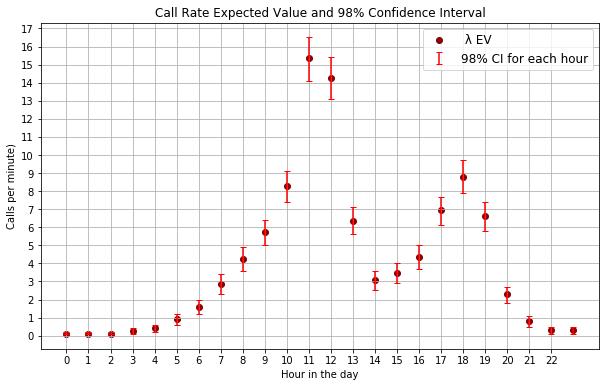

In [12]:
plt.figure(figsize=(10,6))
plt.scatter(range(24), output_array[0,:], color='darkred', label=' λ EV')
plt.errorbar(range(24), output_array[0,:], yerr=output_array[1:,:],
             fmt='none', ecolor='red', capsize=3,
             label='98% CI for each hour')

plt.xlabel('Hour in the day')
plt.ylabel('Calls per minute)')
plt.xticks([i for i in range (0, 23)])
plt.yticks([i for i in range (0, 18)])
plt.grid(True)
plt.title('Call Rate Expected Value and 98% Confidence Interval')
plt.legend(prop={'size': 12})
plt.show()

### 3. 
Write a paragraph (100–200 words) to accompany your plot and present your findings to
the client. Carefully summarize how many calls you expect during different parts of the day,
and how much uncertainty there is in your estimates. Remember that the client is not an
expert in statistics, so make it easy for them to understand. You may also make additional
plots to help communicate your results.

The plot above shows the range of values for possible rates of calls per minute. For every hour of the day, as seen on the x axis, you can find the approximate expected value for minutely number of calls and the error around that value. According to that data, you can make an informed decision on the number of staffing required throughout the day. However, you should not expect this exact number of calls every hour of every day because it is a sample of one day and it does not represent the true rates. The trends can vary due to the holidays, system crashes, time of they year, etc., so I would advise to run the analysis on more data. For now, it would be better to rely on the upper bound of the errorbar so the customers would not have to hang on line for long.

# 2. Stretch Goal (Optional)

Explain how the compute_posterior function from Lesson 2.2 works. We
discussed the function briefly in class. For a complete answer you need to address all the points
below. You can also add any other information you think is relevant to the techniques used in the
function.

The purpose of the function is to multiply the prior and likelihood passed as input arguments
and to return the posterior as output. Explain how the function achieves this purpose using
logarithms.

It is using logarithm to save the computational power. The computational power required for addition is smaller than for the multiplication. It is changing prior and likelihood functions to a logarithmic base and then adds the prior to the likelihood. Summation of the logarithms equals multiplication of the normal base. Therefore, the posterior is in logarithms, as well. 


2. What is the purpose of np.sum() in line 4?

In a normal base, it is actually the multiplication: given that our data is independent and identically distributed, we can say that the probability of given all the data of th likelihood function is the product of each individual probability (product rule). This allows to get all the lambdas.




3. Explain why the maximum of the unnormalized log posterior is subtracted in line 7.

There are two steps of normalization: one is in logarithms. It is a subtraction by the maximum value which is a division in the normal base. So we are dividing by the maximum value. This makes the posterior normalized.


4. Why do we still have to divided by the area in line 10 even after having subtracted the maximum of the unnormalized log posterior in line 7?


This is a safety precaution, just to make sure, that, after transforming from logs, we still have everything normalized. If everything is correct, dividing by the area will be the same as dividing by 1, which will not change the integral area of the distribution. 



5. Create an example where not taking logarithms would cause a problem. Create a prior, likelihood, and data set that fails to produce the correct posterior when we don’t take logs. Show all your code and visualize your results on one or more plots.
 


